In [1]:
import os
import sys

from time import sleep
from time import time
from random import randint

import tensorflow as tf
import cv2
import numpy as np
#import mpld3

from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import svm
from sklearn.utils import shuffle

NUM_CHANNELS = 3 # RGB
IMG_SIZE = (64, 64) # Size of image
PIXEL_DEPTH = 255.0  # Number of levels per pixel.

### Dataset routines ###

In [2]:
def make_feature_vec(img):
    """Resize an 'img' to correct size and make a vector ((60, 60, 3) => (64, 64, 3))"""
    if img.shape[:2] != IMG_SIZE:
        img = cv2.resize(img, IMG_SIZE)
    return normalize(img.reshape(1, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))

def load_dataset(path, dataset_size=-1, downsample=False):
    """Loads samples from image files (e.g '001.png').
    Args:
        path -- path to the images(samples) (default size: 60px X 60px)
        dataset_size -- number of samples to read
        downsample -- downsamples input sample(img) if True
    Returns:
        images -- array (n, 60, 60, 1) of sample vectors as rows
    """
    image_files = os.listdir(path)[:dataset_size]
    # Init 'images' array as samples X features matrix
    images = np.ndarray(shape=(len(image_files), IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS), 
                        dtype=np.float32)
    image_idx = 0
    for filename in image_files:
        if NUM_CHANNELS == 3:
            color_mode = cv2.IMREAD_COLOR
        else:
            color_mode = cv2.IMREAD_GRAYSCALE
        img = cv2.imread(os.path.join(path, filename), color_mode)
        if downsample:
            # Downsample image (scale down by 50%)
            img = cv2.pyrDown(img)
        if img.shape[0] / img.shape[1] != IMG_SIZE[0] / IMG_SIZE[1]:
            continue
        # Convert img matrix to proper format vector (n, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS)
        # Normalize (mean=0, stdev~=0.5)
        images[image_idx, :] = make_feature_vec(img)
        image_idx += 1
    return images

def label_dataset(pos_data, neg_data):
    """Prepare dataset. Combime pos and neg examples, label it & shuffle it.
    Args:
        pos_data -- array of positive samples
        neg_data -- array of negative samples
    Returns:
        dataset -- samples array
        labels -- labels vec
    """
    num_pos_samples = pos_data.shape[0]
    num_neg_samples = neg_data.shape[0] 
    num_total = num_pos_samples + num_neg_samples
    dataset = np.vstack((pos_data, neg_data[:num_neg_samples])).astype(np.float32)
    
    # Label as 1-hot encoding 
    # ex. np.array([1, 0], dtype=np.float32) -- positive
    # ex. np.array([0, 1], dtype=np.float32) -- negative
    
    num_classes = 2 # pos, neg
    labels = np.ndarray(shape=(num_total, num_classes), dtype=np.float32)
    labels[:num_pos_samples] = np.array([1, 0]) # positive
    labels[num_pos_samples:] = np.array([0, 1]) # negative
    
    # Shuffle
    return shuffle(dataset, labels, random_state=0)

def normalize(img):
    """Normalize to have approximately zero mean and standard deviation ~0.5 
    to make training easier down the road. 
    """
    mean = PIXEL_DEPTH / 2
    return (img - mean) / PIXEL_DEPTH

def preview(sample_vec):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.imshow(sample_vec.reshape(IMG_SIZE))
    
def preview_random_examples(pos_data, neg_data):
    %matplotlib inline
    #mpld3.enable_notebook()
    plt.figure(1)
    pos_idx = randint(1, len(pos_data))
    plt.title('POSITIVE (ex. #{})'.format(pos_idx))
    plt.imshow(pos_data[pos_idx].reshape(IMG_SIZE + (NUM_CHANNELS, )))

    plt.figure(2)
    neg_idx = randint(1, len(neg_data))
    plt.title('NEGATIVE (ex.#{})'.format(neg_idx))
    plt.imshow(neg_data[neg_idx].reshape(IMG_SIZE + (NUM_CHANNELS, )))
    plt.show()

### Load positive and negative examples from files into feature vectors ###

In [3]:
pos_path = './dataset/positive/'
neg_path = './dataset/negative/'
pos_data = load_dataset(path=pos_path)
neg_data = load_dataset(path=neg_path) #dataset_size=700)
dataset, labels = label_dataset(pos_data, neg_data)

Number of POSITIVE samples: 617

Number of NEGATIVE samples: 2724



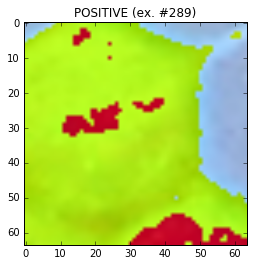

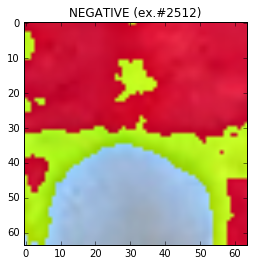

In [4]:
print('Number of POSITIVE samples: %d\n' % len(pos_data))
print('Number of NEGATIVE samples: %d\n' % len(neg_data))
preview_random_examples(pos_data, neg_data)

### Spilt data into training, validation and test sets (60%, 20%, 20%)

In [5]:
idx_train = int(dataset.shape[0] * 0.6)
idx_cv = idx_train + int(dataset.shape[0] * 0.2)
train_dataset = dataset[:idx_train]
train_labels = labels[:idx_train]
valid_dataset = dataset[idx_train:idx_cv]
valid_labels = labels[idx_train:idx_cv]
test_dataset = dataset[idx_cv:]
test_labels = labels[idx_cv:]

del dataset
del labels

#print('No samples missed during spliting: {}'.format(len(labels) == len(train_labels) + len(valid_labels) + len(test_labels)))
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (2004, 64, 64, 3), (2004, 2))
('Validation set', (668, 64, 64, 3), (668, 2))
('Test set', (669, 64, 64, 3), (669, 2))


### Convolutional Neural Network ###
Create CNN with custom architecture.
- CONV1
- RELU1
- POOL1
- CONV2
- RELU2
- POOL2
- FC1
- RELU3
- FC2

In [6]:
### ConvNet with max pooling

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

log_dir = './log'
num_labels = 2

graph = tf.Graph()

with graph.as_default():

    # Input data.
    tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    tf_single_sample = tf.placeholder(tf.float32, shape=(1, IMG_SIZE[0], IMG_SIZE[1], NUM_CHANNELS))

    # Variables.
    layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, NUM_CHANNELS, depth], stddev=0.1))
    # [5, 5, 3, 16]
    layer1_biases = tf.Variable(tf.zeros([depth]))

    layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
    # [5, 5, 16, 16]
    layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
      [IMG_SIZE[0] // 8 * IMG_SIZE[1] // 8 * depth, num_hidden], stddev=0.1))
    # [1024, 64]
    layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
    layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
    # [64, 2]
    layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))

    # Model.
    def model(data):
        conv = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer1_biases)
        hidden = tf.nn.max_pool(hidden, [1, 4, 4, 1], [1, 4, 4, 1], padding='SAME')

        conv = tf.nn.conv2d(hidden, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + layer2_biases)
        hidden = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')

        shape = hidden.get_shape().as_list()
        reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)

        return tf.matmul(hidden, layer4_weights) + layer4_biases

    # Training computation.
    logits = model(tf_train_dataset)
    loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))

    # Optimizer + LR decay.
    global_step = tf.Variable(0)  # count the number of steps taken.
    learning_rate = tf.train.exponential_decay(0.005, global_step, 100, 0.96) 
    # Get test set accuracy of 95.0%
    # (0.005, global_step, 1000, 0.96)
    optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
    # Optimizer.
    #optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)

    # Predictions for the training, validation, and test data.
    train_prediction = tf.nn.softmax(logits)
    valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
    test_prediction = tf.nn.softmax(model(tf_test_dataset))
    sample_prediction = tf.nn.softmax(model(tf_single_sample))

### Skip this step and go to 'Restore saved model.' if you have your model saved. ###
### =================================================== ###

### Train CNN  ###
Train & save trained model to file './models/model_[accuracy].ckpt'

In [9]:
num_steps = 1001 #10001
num_fetch_results = 50
acc_list = []

def accuracy_func(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
            / predictions.shape[0])

with tf.Session(graph=graph) as session:    
    tf.initialize_all_variables().run()
    print('Initialized')

    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    for step in range(num_steps):
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % num_fetch_results == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
            print('Minibatch accuracy: %.1f%%' % accuracy_func(predictions, batch_labels))
            val_accuracy = accuracy_func(valid_prediction.eval(), valid_labels)
            print('Validation accuracy: %.1f%%' % val_accuracy)
            acc_list.append(val_accuracy)
    test_accuracy = accuracy_func(test_prediction.eval(), test_labels)
    print('Test accuracy: %.1f%%' % test_accuracy)
    
    # Save variables to file
    tf_model_filename = ("model_%.2f.ckpt" % test_accuracy)
    save_path = saver.save(session, "./models/%s" % tf_model_filename)
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 0.606306
Minibatch accuracy: 75.0%
Validation accuracy: 81.4%
Minibatch loss at step 50: 0.590436
Minibatch accuracy: 68.8%
Validation accuracy: 82.3%
Minibatch loss at step 100: 0.255235
Minibatch accuracy: 87.5%
Validation accuracy: 81.4%
Minibatch loss at step 150: 0.287931
Minibatch accuracy: 93.8%
Validation accuracy: 87.6%
Minibatch loss at step 200: 0.582695
Minibatch accuracy: 81.2%
Validation accuracy: 91.5%
Minibatch loss at step 250: 0.251761
Minibatch accuracy: 87.5%
Validation accuracy: 92.7%
Minibatch loss at step 300: 0.067852
Minibatch accuracy: 100.0%
Validation accuracy: 91.6%
Minibatch loss at step 350: 0.193577
Minibatch accuracy: 93.8%
Validation accuracy: 90.9%
Minibatch loss at step 400: 0.237031
Minibatch accuracy: 87.5%
Validation accuracy: 92.4%
Minibatch loss at step 450: 0.150627
Minibatch accuracy: 93.8%
Validation accuracy: 94.0%
Minibatch loss at step 500: 0.102008
Minibatch accuracy: 100.0%
Validation accuracy: 94.3%

### Plot training curves ###

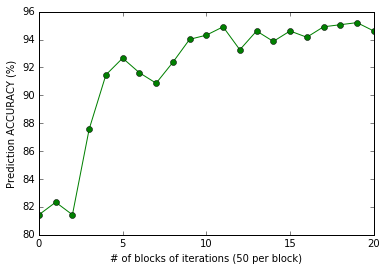

In [10]:
%matplotlib inline
plt.plot(acc_list, '-go')
plt.xlabel('# of blocks of iterations (%s per block)' % num_fetch_results)
plt.ylabel('Prediction ACCURACY (%)')
plt.show()

### ===================================================
# Predict on unknown data.

### Detect capped brood cells on WHOLE image ###
Use classifier on each single sample subimage, acquired with sliding window.

In [7]:
# Image to detect on.
FILENAME = '003.png'
PATH = '/home/chip/Dropbox/LITS/ML-003/dataset/processed_dataset/prespective_correction'

### Restore saved model.
Change the 'tf_model_filename' to your saved model filename.

In [8]:
tf_model_filename = 'model_95.98.ckpt'  # Model name file to restore TF variables from.
tf_model_path = os.path.join('./models/', tf_model_filename)

PRED_THRESHOLD = 0.90  # Prediction threshold

### Manually select a single CELL with a bounding box.
<img src="how_to_select.png">
### (Use 's' key to save measurements.)

In [9]:
import bee_frame
from nms import non_max_suppression_fast

frame = bee_frame.BeeFrame()
frame.load_image(PATH, FILENAME)

### PRE-PROCESSING ###
# Normalize histogram and smooth img.
frame.image.hitogram_normalization()
frame.image.blur()
######################


### PRESS 'S' key to save measurements. ###
frame.get_cell_size()
#frame.step_size = 10
#frame.cell_size = 55
print('cell size: {}\n'
      'step size: {}'.format(frame.cell_size, frame.step_size))

# Create sliding window generator.
samples_gen = frame.sliding_window()
boxes_list = []  # Detected bounding boxes coordinates.

#### Restore tf session. And use the model for prediction. ###
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    saver = tf.train.Saver()
    saver.restore(session, tf_model_path)
    print("Model restored.")

    # Iterate through all the samples
    start = time()
    for x, y, window in samples_gen:
        feed_dict = {tf_single_sample : np.array(make_feature_vec(window))}
        prediction = session.run(
            [sample_prediction], feed_dict=feed_dict)
        if prediction[0][0][0] > PRED_THRESHOLD:
            end_x = x + frame.cell_size
            end_y = y + frame.cell_size
            boxes_list.append([x, y, end_x, end_y])
print('elapsed: {:0.2f}'.format(time() - start))

# Use NMS on detection results, to supress duplicates in detection.
boxes_np = np.array(boxes_list)
boxes_np_nms = non_max_suppression_fast(boxes_np, 0.3)
############################

cell size: 59
step size: 14
Initialized
Model restored.
elapsed: 113.66


### Show Results

In [11]:
preview_img = frame.image._img.copy()
for box_coordinates in boxes_np_nms:
        frame.image.draw_circle(box_coordinates, preview_img)

cv2.namedWindow(frame.WIN_NAME, cv2.WINDOW_NORMAL)
frame.preview(preview_img)
cv2.destroyAllWindows()

print('Capped brood cells detected: {}'.format(boxes_np_nms.shape[0]))

Capped brood cells detected: 1365
